# An Improved Bio-Physical Parameterization for Radiant Heating in the Surface Ocean

Witte, Subramaniam, and Zappa

In [1]:
#computation packages
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import datetime as dt
import itertools
import math
from scipy.optimize import curve_fit
from scipy.io import loadmat
import scipy
from scipy import signal as signal

#plotting packages
import matplotlib as mpl
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib.patches import ConnectionPatch
import colorcet as cc
%matplotlib inline

#physical pacakages
import gsw
import metpy
import metpy.calc
from metpy.units import units

#utilities
import glob
from tqdm import tqdm
import copy
import matlab.engine

#custom functions
%load_ext autoreload
%autoreload

start19, end19 = dt.datetime(2019,11,21,6,0,0), dt.datetime(2019,12,18,18,0,0)

# Specify path to data package here:
Data package can be downloaded from Columbia Academic Commons: https://doi.org/10.7916/wmdm-vm51

In [2]:
data_path = '../../../Publications/2. Radiant Heating Parameterization/Initial Submission JGR/Data Package/'

## Figure 1: Graphical Summary of Spectral Radiant Heating Model

In [3]:
fk = xr.open_dataset(data_path+'falkor_2019_shipboard_data_10min.nc')

Text(0.5, 0.95, 'Graphical Summary of Spectral Radiant Heating Model')

<ipython-input-2-9e612b660348>:58: RuntimeWarning: divide by zero encountered in true_divide
  inv = lambda x:1/x


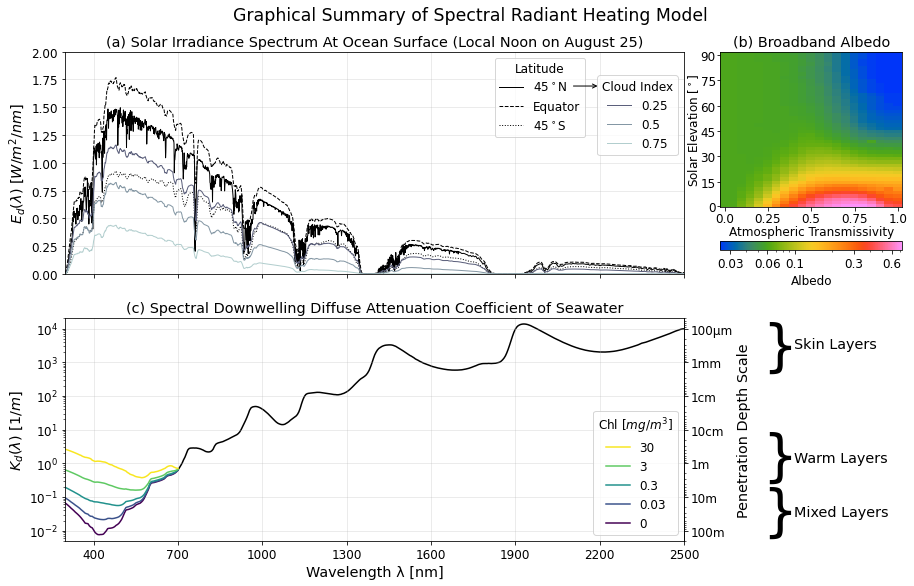

In [2]:
%autoreload
from Radiant_Heating_Modeling_Toolbox import solar_spectrum_d15, cloud_model_s99, albedo_p72, Kd_spectrum_m07

fig = plt.figure(figsize=(15,9))

#---------------------SURFACE SPECTRUM--------------------------
axx0 = plt.subplot2grid(shape=(2,4),loc=(0,0),rowspan=1,colspan=3,fig=fig)

smooth = 10 #number of wavelength bins to skip over for displaying variability cleanly
#start with the main spectrum being mid-fall at 45N, then do equator and 45S in broken lines
longitude = 0
time_utc = dt.datetime(2019,8,25,12,0,0)
Ed_equator,sza,Dse = solar_spectrum_d15(time_utc,0,longitude)
Ed_45N,sza,Dse = solar_spectrum_d15(time_utc,45,longitude)
Ed_45S,sza,Dse = solar_spectrum_d15(time_utc,-45,longitude)

heq, = axx0.plot(Ed_equator.rolling(smooth,center=True).mean(),'--k',linewidth=1)
h45s, = axx0.plot(Ed_45S.rolling(smooth,center=True).mean(),':k',linewidth=1)
h45n, = axx0.plot(Ed_45N.index,Ed_45N.values,'k',linewidth=1)

CIs = [0.25,0.5,0.75]
handles= []
for CI in CIs:
    c = plt.cm.bone((CI+0.3)/1.35)
    csi = pd.Series(data=cloud_model_s99(CI,Ed_45N), index=Ed_45N.index).rolling(smooth,center=True).mean()
    h1, = axx0.plot(csi.index,csi.values,color=c,linewidth=1)
    handles.append(h1)

l1 = axx0.legend(handles,CIs,loc='upper right',fontsize='large',title='Cloud Index',title_fontsize='large',bbox_to_anchor=(1,0.92))
axx0.legend([h45n,heq,h45s],['45$^\circ$N','Equator','45$^\circ$S'],fontsize='large',title='Latitude',title_fontsize='large',loc='upper right',bbox_to_anchor=(0.85,1))
axx0.add_artist(l1)
axx0.annotate("", xy=(2200, 1.69), xytext=(2100, 1.69),arrowprops=dict(arrowstyle="->"),zorder=10)

axx0.set_ylim([0,2])
axx0.set_title('(a) Solar Irradiance Spectrum At Ocean Surface (Local Noon on August 25)',fontsize='x-large')
axx0.set_ylabel('$E_d(λ)$ [$W/m^2/nm$]',fontsize='x-large')

#---------------------KD SPECTRUM--------------------------
axx1 = plt.subplot2grid(shape=(2,4),loc=(1,0),rowspan=1,colspan=3,fig=fig)

handles = []
for Chl,c in zip([0,0.03,0.3,3,30],[0,0.25,0.5,0.75,0.99]):
    color = plt.cm.viridis(c)
    kd_param = Kd_spectrum_m07(Chl)
    h, = axx1.plot(kd_param.loc[300:700].index,kd_param.loc[300:700],color=color)
    handles.append(h)
    
kd_param = Kd_spectrum_m07(0)    
h2, = axx1.plot(kd_param.loc[700:2500].index,kd_param.loc[700:2500],'k',zorder=0)
handles.reverse()
axx1.legend(handles,[30,3,0.3,0.03,0],loc='lower right',fontsize='large',title='Chl [$mg/m^3$]',title_fontsize='large')
axx1.set_title('(c) Spectral Downwelling Diffuse Attenuation Coefficient of Seawater',fontsize='x-large')
axx1.set_ylabel('$K_d(λ)$ [$1/m$]',fontsize='x-large')
axx1.set_yscale('log')
axx1.set_ylim([5e-3,2e4])
axx1.set_xlabel('Wavelength λ [nm]',fontsize='x-large')

inv = lambda x:1/x
ax2 = axx1.secondary_yaxis('right',functions=(inv,inv))
ax2.set_ylabel('Penetration Depth Scale',fontsize='x-large')
ax2.set_yticks([1e2,1e1,1e0,1e-1,1e-2,1e-3,1e-4])
ax2.set_yticklabels(['100m','10m','1m','10cm','1cm','1mm','100μm'],fontsize='large')

for axis in [axx0,axx1]:
    axis.set_xlim([299,2500])
    axis.set_xticks([400,700,1000,1300,1600,1900,2200,2500])
    axis.tick_params(axis='both',labelsize='large')
    axis.grid(alpha=0.3)
axx0.set_xticklabels([])

#---------------------ALBEDO--------------------------
axx3 = plt.subplot2grid(shape=(2,4),loc=(0,3),rowspan=1,colspan=1,fig=fig)

p72raw = pd.read_csv('./Payne72_albedoLUT.csv', index_col=0)
p72 = xr.DataArray(data=p72raw.values, coords={'T':(['T'],p72raw.index), 'elev':(['elev'],np.arange(0,92,2))}).transpose()

h3 = axx3.pcolormesh(p72,cmap=cc.cm.rainbow_bgyrm_35_85_c71, norm=mpl.colors.LogNorm(vmin=p72.min(), vmax=p72.max()))

#pcolormesh is being a huge pain in my ass so just labeling the ticks manually
axx3.set_yticks([0.5,7.5,15,22.5,30,37.5,45])
axx3.set_yticklabels([0,15,30,45,60,75,90],fontsize='large')
axx3.set_xticks([0.5,5.5,10.5,15.5,20.5])
axx3.set_xticklabels([0.0,0.25,0.5,0.75,1.0],fontsize='large')
axx3.tick_params(axis='both',pad=1)

axx3.set_ylabel('Solar Elevation [$^\circ$]',fontsize='large',labelpad=-1)
axx3.set_xlabel('Atmospheric Transmissivity',fontsize='large',labelpad=0)

cbar= fig.colorbar(h3, orientation='horizontal',ticks=[0.03,0.06,0.1,0.3,0.6])#
cbar.set_label(label='Albedo',size='large')
cbar.ax.set_xticklabels([0.03,0.06,0.1,0.3,0.6],fontsize='large')

axx3.set_title('(b) Broadband Albedo',fontsize='x-large')

#---------------LAYER LABELS-------------
fig.text(0.77,0.4,'}',fontsize=55)
fig.text(0.77,0.23,'}',fontsize=55)
fig.text(0.77,0.145,'}',fontsize=55)

fig.text(0.8,0.423,'Skin Layers',fontsize='x-large')
fig.text(0.8,0.247,'Warm Layers',fontsize='x-large')
fig.text(0.8,0.163,'Mixed Layers',fontsize='x-large')

plt.suptitle('Graphical Summary of Spectral Radiant Heating Model',fontsize='xx-large',y=0.95)


#### Simplifying the model to usable parameterization:

In [3]:
#calculate Kds
%autoreload
from Radiant_Heating_Modeling_Toolbox import solar_spectrum_d15, cloud_model_s99, albedo_p72, Kd_spectrum_m07

###-------------derive UV-band and 3-visible-band Morel coefficients-----------###
split1,split2=510,600
morel07 = pd.read_csv('./Morel07_BioOpticalParameterization.csv',index_col=0)
time_utc = dt.datetime(2019,8,25,12,0,0)
Ed,sza,dse = solar_spectrum_d15(time_utc,0,0) #get example spectrum

#--------UV--------- weighted average in UV because the 300-350nm Irradiance is so much smaller, but the Kds are way bigger
Ed_UV = Ed.loc[300:400]
mUV = morel07.to_xarray().interp_like(Ed_UV.to_xarray().rename({'nm':'wavelength'})).to_pandas()
Kw_UV = np.exp(np.average(np.log(mUV.Kw.values),weights=Ed_UV.values))
chi_UV = np.exp(np.average(np.log(mUV.chi.values),weights=Ed_UV.values))
e_UV = np.exp(np.average(np.log(mUV.e.values),weights=Ed_UV.values))
#--------blue---------
Ed_bg = Ed.loc[400:split1]
mbg = morel07.to_xarray().interp_like(Ed_bg.to_xarray().rename({'nm':'wavelength'})).to_pandas()
Kw_bg = np.exp(np.average(np.log(mbg.Kw.values)))
chi_bg = np.exp(np.average(np.log(mbg.chi.values)))
e_bg = np.exp(np.average(np.log(mbg.e.values)))
#--------yellow---------
Ed_y = Ed.loc[split1:split2]
my = morel07.to_xarray().interp_like(Ed_y.to_xarray().rename({'nm':'wavelength'})).to_pandas()
Kw_y = np.exp(np.average(np.log(my.Kw.values)))
chi_y = np.exp(np.average(np.log(my.chi.values)))
e_y = np.exp(np.average(np.log(my.e.values)))
#----------red-----------
Ed_r = Ed.loc[split2:700]
mr = morel07.to_xarray().interp_like(Ed_r.to_xarray().rename({'nm':'wavelength'})).to_pandas()
Kw_r = np.exp(np.average(np.log(mr.Kw.values)))
chi_r = np.exp(np.average(np.log(mr.chi.values)))
e_r = np.exp(np.average(np.log(mr.e.values)))

print(f'UV: Kw={np.round(Kw_UV,4)}, χ={np.round(chi_UV,4)}, e={np.round(e_UV,4)}')
print(f'Blue: Kw={np.round(Kw_bg,4)}, χ={np.round(chi_bg,4)}, e={np.round(e_bg,4)}')
print(f'Yellow: Kw={np.round(Kw_y,4)}, χ={np.round(chi_y,4)}, e={np.round(e_y,4)}')
print(f'Red: Kw={np.round(Kw_r,4)}, χ={np.round(chi_r,4)}, e={np.round(e_r,4)}')

UV: Kw=0.0218, χ=0.1758, e=0.6541
Blue: Kw=0.0119, χ=0.1048, e=0.633
Yellow: Kw=0.0665, χ=0.0582, e=0.5342
Red: Kw=0.3608, χ=0.0585, e=0.4723


In [4]:
#specify fractions
Auv,Ab,Ay,Ar,Air = 0.06,0.17,0.14,0.14,0.49
np.sum([Auv,Ab,Ay,Ar,Air])

1.0

In [6]:
def arctanIR_withexp(x,A,B,C,D):
    x=np.array(x)
    return  np.exp(-D*x)*(1 - A*np.arctan(C+B*x))

Kd = Kd_spectrum_m07(0).loc[700:2500]

frac1s, kD1s, frac1_errs, kD1_errs = [],[],[],[]
frac2s, kD2s, frac2_errs, kD2_errs = [],[],[],[]
for lat,linestyle in zip([-45,0,45],[':','-','--']):
    Ed,sza,dse = solar_spectrum_d15(time_utc,lat,0)
    #get albedo
    Ed_INT = np.trapz(y=Ed,x=Ed.index)
    elev = 90-sza
    S = 1353 #[W/m^2], this is the value given in Payne 1972 and Aligns with NASA standards, WMO likes 1367
    T = Ed_INT/(S*np.sin(np.deg2rad(elev))*(Dse**2))
    α = albedo_p72(elev, T)
    Ed = Ed*(1-α)
    
    
    Ed_IR = Ed.loc[700:2500]
    Kd_IR = Kd.to_xarray().interp_like(Ed_IR.to_xarray().rename({'nm':'wavelength'})).to_pandas()
    Ed_IRint = np.trapz(y=Ed_IR,x=Ed_IR.index)

    #------evaluate profile-----
    start, stop=0.001,10 #depth range [m]
    num = int(stop/start)
    depths = np.linspace(start, stop, num)
    #depths = np.logspace(np.log10(start),np.log10(stop),num)

    I_IR = []
    for z in depths:
        #Irradiance at this depth
        I_IR.append(np.trapz(Ed_IR.values*np.exp(-Kd_IR.values*z),x=Ed_IR.index))
    
    I_IR = xr.DataArray(data=I_IR,coords={'depth':(['depth'],depths)})

    #fit to arctan curve
    poptD, pcovD = curve_fit(arctanIR_withexp, I_IR.depth.values, I_IR.values/Ed_IRint)
    A = poptD[0]
    B = poptD[1]
    C = poptD[2]
    D = poptD[3]
    
    print(A,B,C,D)

0.47288664087551 29.325677239957322 0.6691058089247303 1.882567027029047
0.47546369082141426 29.85193658833539 0.66431874979237 1.8725397313716614
0.4746032192605137 29.6648979143432 0.6648872039829867 1.874694972990786


In [7]:
#define IR function with constants
C1,C2,C3,C4 = 1.87, 0.47, 0.66, 30

def arctanIR_withexp(x,C1,C2,C3,C4):
    x=np.array(x)
    return  np.exp(-C1*x)*(1 - C2*np.arctan(C3+C4*x))

## Figure 3: Comparison of Parameterizations

In [5]:
%autoreload
from Radiant_Heating_Modeling_Toolbox import final_param, I_ps77, I_ps81, I_s82, I_os00, Kd_spectrum_m07

ex = fk.sel(time='2019-11-25 23:00:00')
lat, lon, time, SW = ex.Latitude.values.item(), ex.Longitude.values.item(), ex.time.values, ex.SW.values.item()
#real values for this example time:
CI = 0.09
sza = 18
α = 0.045
I0m = SW*(1-α) #other parameterizations need post-albedo input

#calculate irradiance profiles
Chl = [0.03,0.3,3] #Chl range
start, stop=0.01,100 #depth range [m]
num = int(stop/start)
depths = np.linspace(start, stop, num)

Ed_prof_list,Heat_prof_list,IntHeat_prof_list = [],[],[]
for C in tqdm(Chl):
    #extract Kd parameterization at that chlorophyll concentration
    Kd = Kd_spectrum_m07(C)

    Ed, ps77, ps81, s82, os00 = [],[],[],[],[]
    HEd, Hps77, Hps81, Hs82, Hos00 = [],[],[],[],[]
    for z in depths:
        #Irradiance at this depth
        Ed.append(final_param(SW,C,z))
        ps77.append(I_ps77(I0m, z))
        ps81.append(I_ps81(I0m, z))
        s82.append(I_s82(I0m, z))
        os00.append(I_os00(SW, z, C, CI, sza))
        
        #Total heating to layer above this depth (Ed0- minus Ed(z))
        HEd.append(I0m-Ed[-1])
        Hps77.append(I0m-ps77[-1])
        Hps81.append(I0m-ps81[-1])
        Hs82.append(I0m-s82[-1])
        Hos00.append(I0m-os00[-1])
        
    #create xarrays for irradiance and heating with depth
    Ed_prof = xr.Dataset(coords={'Chl':[C],'depth':depths},
                         data_vars={'Ed':(['Chl','depth'],[Ed]),
                                    'os00':(['Chl','depth'],[os00]),
                                    'ps77':(['depth'],ps77),
                                    'ps81':(['depth'],ps81),
                                    's82':(['depth'],s82)})
    Ed_prof_list.append(Ed_prof)
    
    #total heating to layer above this depth
    IntHeat_prof = xr.Dataset(coords={'Chl':[C],'depth':depths},
                         data_vars={'Ed':(['Chl','depth'],[HEd]),
                                    'os00':(['Chl','depth'],[Hos00]),
                                    'ps77':(['depth'],Hps77),
                                    'ps81':(['depth'],Hps81),
                                    's82':(['depth'],Hs82)})
    IntHeat_prof_list.append(IntHeat_prof)
    
    #calculate heating profiles dE/dz
    dz = start #start depth is the interval between subsequent depths as written above
    Heat_prof = xr.Dataset(coords={'Chl':[C],'depth':np.linspace(start+(dz/2), stop-(dz/2), num-1)},
                           data_vars={'Ed':(['Chl','depth'],[(np.array(Ed)[:-1] - np.array(Ed)[1:])/dz]),
                                      'os00':(['Chl','depth'],[(np.array(os00)[:-1] - np.array(os00)[1:])/dz]),
                                      'ps77':(['depth'],(np.array(ps77)[:-1] - np.array(ps77)[1:])/dz),
                                      'ps81':(['depth'],(np.array(ps81)[:-1] - np.array(ps81)[1:])/dz),
                                      's82':(['depth'],(np.array(s82)[:-1] - np.array(s82)[1:])/dz)})
    
    Heat_prof_list.append(Heat_prof)
        
Ed_profiles = xr.merge(Ed_prof_list)    
Heat_profiles = xr.merge(Heat_prof_list)
IntHeat_profiles = xr.merge(IntHeat_prof_list)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.42it/s]


Text(0.5, 0.95, 'Comparison of Parameterizations')

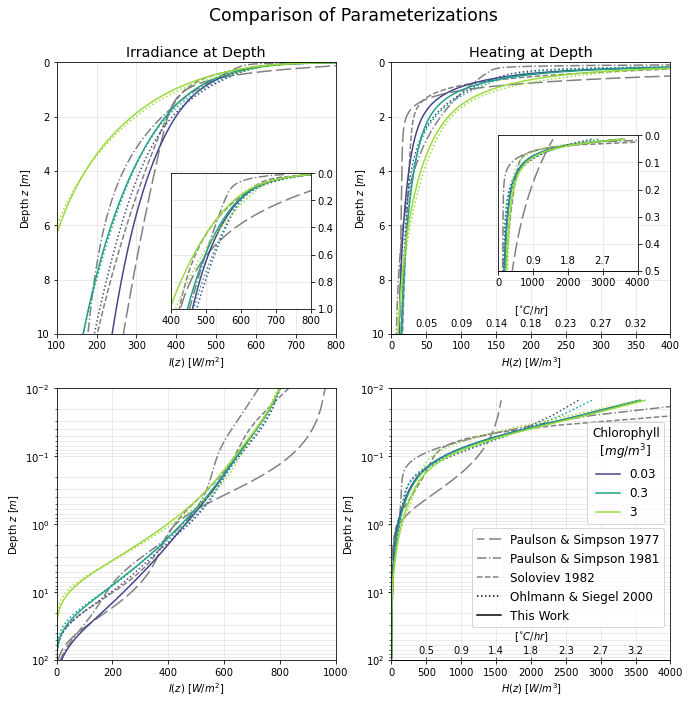

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#plot - 4 x 4: Linear axes on top, Logarithmic axes on bottom, Ed on Left, Heating on Middle, Integrated Heating to that depth on right
fig,axx = plt.subplots(nrows=2,ncols=2,figsize=(11,11))

#define linestyles for consistency
ls_o00 = ':' #dot
ls_s82 = '--' #small dash
ls_ps81 = '-.' #dashdot
ls_ps77 = (5, (10, 3)) #big dash
colors = [0.21,0.57,0.85]

#formatting each row
for axis in axx[0,:]:
    #axis.set_xscale('log')
    axis.set_ylim([0, 10])
    axis.invert_yaxis()
    axis.grid(which='both',alpha=0.3)

for axis in axx[1,:]:
    #axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_ylim([1e-2,1e2])
    axis.invert_yaxis()
    axis.grid(which='both',alpha=0.3)

#-----------IRRADIANCE COLUMN------------
#initialize inset axes
axins00 = inset_axes(axx[0,0], width="50%", height="50%", loc='lower right', borderpad=2.5)

for axis in np.append(axx[:,0],axins00):
    axis.plot(Ed_profiles.ps77, Ed_profiles.depth, color='gray',linestyle=ls_ps77)
    axis.plot(Ed_profiles.ps81, Ed_profiles.depth, color='gray',linestyle=ls_ps81)
    axis.plot(Ed_profiles.s82, Ed_profiles.depth, color='gray',linestyle=ls_s82)
    
    for Chl,c in zip(Ed_profiles.Chl.values,colors):
        color = plt.cm.viridis(c) 
        Ed = Ed_profiles.sel(Chl=Chl)
        axis.plot(Ed.Ed,Ed.depth, color=color)
        axis.plot(Ed.os00,Ed.depth, color=color, linestyle=ls_o00)
    
axx[0,0].set_xlabel('$I(z)$ [$W/m^2$]')
axx[0,0].set_ylabel('Depth $z$ [$m$]')
axx[1,0].set_xlabel('$I(z)$ [$W/m^2$]')
axx[1,0].set_ylabel('Depth $z$ [$m$]')

#-----------HEATING COLUMN------------
axins01 = inset_axes(axx[0,1], width="100%", height="100%", bbox_to_anchor=(.4, .25, .5, .5), bbox_transform=axx[0,1].transAxes)

for axis in np.append(axx[:,1],axins01):
    axis.plot(Heat_profiles.ps77, Heat_profiles.depth, color='gray',linestyle=ls_ps77)
    axis.plot(Heat_profiles.ps81, Heat_profiles.depth, color='gray',linestyle=ls_ps81)
    axis.plot(Heat_profiles.s82, Heat_profiles.depth, color='gray',linestyle=ls_s82)
    
    handles_chl = []
    for Chl,c in zip(Heat_profiles.Chl.values,colors):
        color = plt.cm.viridis(c) 
        H = Heat_profiles.sel(Chl=Chl)
        hchl, = axis.plot(H.Ed,H.depth, color=color)
        axis.plot(H.os00,H.depth, color=color, linestyle=ls_o00)
        handles_chl.append(hchl)
    
axx[0,1].set_xlabel('$H(z)$ [$W/m^3$]')
axx[0,1].set_ylabel('Depth $z$ [$m$]')
axx[1,1].set_xlabel('$H(z)$ [$W/m^3$]')
axx[1,1].set_ylabel('Depth $z$ [$m$]')


#-----------AXIS LIMITS------------
axins00.set_ylim(0,1)
axins00.invert_yaxis()
axins00.set_xlim([400,800])
axins00.grid(alpha=0.3)
axins00.yaxis.tick_right()

axins01.set_ylim(0,0.5)
axins01.invert_yaxis()
axins01.set_xlim([0,4000])
axins01.grid(alpha=0.3)
axins01.yaxis.tick_right()
        
axx[0,0].set_xlim(100,800)
axx[1,0].set_xlim(0,1000)
axx[0,1].set_xlim(0,400)
axx[1,1].set_xlim(0,4000)

#-----------SECONDARY HEATING AXES------------
ρ = 1025 #[kg/m^3]
cp = 3850 #[J/kg/C]

def heat_to_temp(heat):
    '''Convert heating rate in W/m^3 to rate in C/hr using factor of 1/(rho*cp)*(3600s/1hr)'''
    temp = 3600*heat/(ρ*cp)
    return temp
    
def temp_to_heat(temp):
    '''Convert heating rate in C/hr to rate in W/m^3 using factor of rho*cp*(1hr/3600s)'''
    heat = temp*(ρ*cp)/3600
    return heat
    
secax = axx[0,1].secondary_xaxis('bottom', functions=(heat_to_temp, temp_to_heat))
secax.set_xticks([heat_to_temp(x) for x in axx[0,1].get_xticks()[1:]][:-1])
secax.set_xticklabels(np.round(secax.get_xticks(),2))
secax.tick_params(axis='x',direction='in',pad=-15)
secax.set_xlabel('[$^{\circ}C/hr$]',labelpad=-30)

secax2 = axins01.secondary_xaxis('bottom', functions=(heat_to_temp, temp_to_heat))
secax2.set_xticks([heat_to_temp(x) for x in [1000,2000,3000]])#[:-1])
secax2.set_xticklabels(np.round(secax2.get_xticks(),1))
secax2.tick_params(axis='x',direction='in',pad=-15)
#secax.set_xlabel('[$^{\circ}C/hr$]',labelpad=-30)

secax3 = axx[1,1].secondary_xaxis('bottom', functions=(heat_to_temp, temp_to_heat))
secax3.set_xticks([heat_to_temp(x) for x in axx[1,1].get_xticks()[1:]][:-1])
secax3.set_xticklabels(np.round(secax3.get_xticks(),1))
secax3.tick_params(axis='x',direction='in',pad=-15)
secax3.set_xlabel('[$^{\circ}C/hr$]',labelpad=-30)

#--------------LEGENDS-----------------
l1 = axx[1,1].legend(handles_chl,[0.03,0.3,3],loc='lower right',bbox_to_anchor=(1,0.48),title='Chlorophyll\n  [$mg/m^3$]',fontsize='large',title_fontsize='large')

ls_o00 = ':' #dot
ls_s82 = '--' #small dash
ls_ps81 = '-.' #dashdot
ls_ps77 = (5, (10, 3)) #big dash

artist_77 = mlines.Line2D([], [], color='gray', linestyle=ls_ps77)
artist_81 = mlines.Line2D([], [], color='gray', linestyle=ls_ps81)
artist_82 = mlines.Line2D([], [], color='gray', linestyle=ls_s82)
artist_00 = mlines.Line2D([], [], color='k', linestyle=ls_o00)
artist_23 = mlines.Line2D([], [], color='k')

axx[1,1].legend([artist_77,artist_81,artist_82,artist_00,artist_23],['Paulson & Simpson 1977','Paulson & Simpson 1981','Soloviev 1982','Ohlmann & Siegel 2000','This Work'],loc='lower right',bbox_to_anchor=(1,0.1),fontsize='large')
axx[1,1].add_artist(l1)



#----------FINAL FORMATTING------------
axx[0,0].set_title('Irradiance at Depth', fontsize='x-large')
axx[0,1].set_title('Heating at Depth', fontsize='x-large')

plt.suptitle(f'Comparison of Parameterizations',fontsize='xx-large',y=0.95)       


## Figure 4: Simplified Parameterization vs. Full Spectral Model

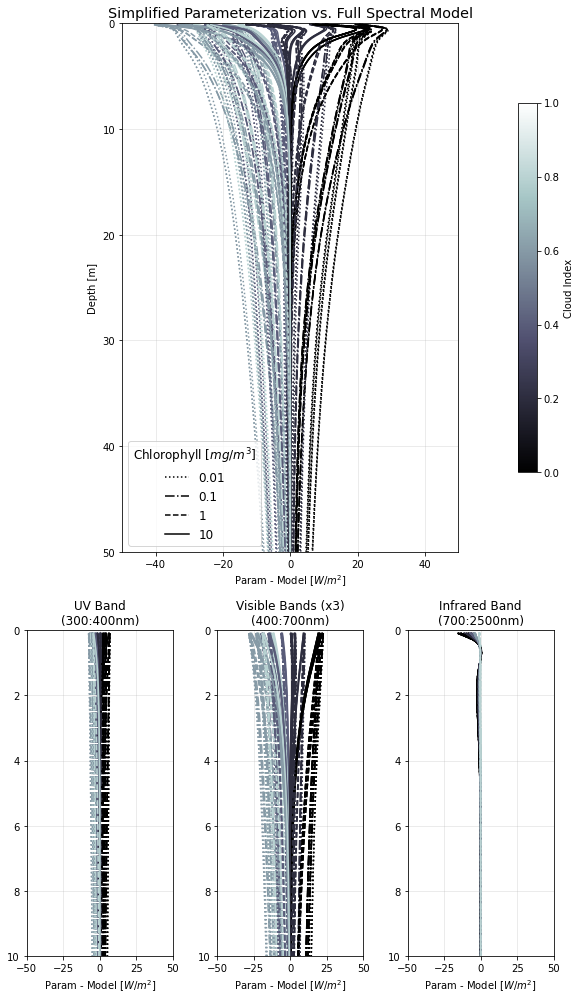

In [10]:
%autoreload
from Radiant_Heating_Modeling_Toolbox import solar_spectrum_d15, cloud_model_s99, albedo_p72, Kd_spectrum_m07
###-------------plot param vs. model differences across many conditions-----------###
time_utc = dt.datetime(2019,8,25,12,0,0)
split1=510
split2=600

fig = plt.figure(figsize=(8,14))

axx = plt.subplot2grid(shape=(5,6),loc=(0,1),rowspan=3,colspan=4)
axx1 = plt.subplot2grid(shape=(5,6),loc=(3,0),rowspan=2,colspan=2)
axx2 = plt.subplot2grid(shape=(5,6),loc=(3,2),rowspan=2,colspan=2)
axx3 = plt.subplot2grid(shape=(5,6),loc=(3,4),rowspan=2,colspan=2)

UVs, Bs, Ys, Rs, IRs, Tots = [],[],[],[],[],[]
αs = []
α_constant = 0.045

for lat in [-45,0,45]:
    for lon in [-10,0,10]:
        Eclear,sza,dse = solar_spectrum_d15(time_utc,lat,lon)
        
        for CI in [0,0.2,0.4,0.6,0.8]:
            color = plt.cm.bone(CI)
            
            Ed0p = cloud_model_s99(CI,Eclear)
            SW = np.trapz(y=Ed0p,x=Ed0p.index)
            
            elev = 90-sza
            S = 1353 #[W/m^2], this is the value given in Payne 1972 and Aligns with NASA standards, WMO likes 1367
            T = SW/(S*np.sin(np.deg2rad(elev))*(Dse**2))
            α = albedo_p72(elev, T)
            αs.append(α)
            Ed = Ed0p*(1-α)
            Tots.append(np.trapz(y=Ed,x=Ed.index))
            
            Ed_ca = Ed0p*(1-α_constant)
            Ed_INT = np.trapz(y=Ed_ca,x=Ed_ca.index)

            Ed_UV = Ed.loc[300:400]
            Ed_UVINT = np.trapz(y=Ed_UV,x=Ed_UV.index)
            UVs.append(Ed_UVINT)
            
            Ed_bg = Ed.loc[400:split1]
            Ed_bgINT = np.trapz(y=Ed_bg,x=Ed_bg.index)
            Bs.append(Ed_bgINT)

            Ed_y = Ed.loc[split1:split2]
            Ed_yINT = np.trapz(y=Ed_y,x=Ed_y.index)
            Ys.append(Ed_yINT)
            
            Ed_r = Ed.loc[split2:700]
            Ed_rINT = np.trapz(y=Ed_r,x=Ed_r.index)
            Rs.append(Ed_rINT)
            
            Ed_vis = Ed.loc[400:700]
            Ed_visINT = Ed_bgINT + Ed_yINT + Ed_rINT
            
            Ed_IR = Ed.loc[700:2500]
            Kd = Kd_spectrum_m07(0.01) #just get any Kd spectrum, Chl doesnt affect IR wavelengths
            Kd_IR = Kd.to_xarray().interp_like(Ed_IR.to_xarray().rename({'nm':'wavelength'})).to_pandas()
            Ed_IRint = np.trapz(y=Ed_IR,x=Ed_IR.index)
            IRs.append(Ed_IRint)

            for Chl,linestyle in zip([0.01,0.1,1,10],[':','-.','--','-']):
                
                Kd = Kd_spectrum_m07(Chl)

                #--------UV---------
                Kd_UV = Kd.to_xarray().interp_like(Ed_UV.to_xarray().rename({'nm':'wavelength'})).to_pandas()
                Kd_UVav = Kw_UV + chi_UV*(Chl**e_UV)

                #--------blue---------
                Kd_bg = Kd.to_xarray().interp_like(Ed_bg.to_xarray().rename({'nm':'wavelength'})).to_pandas()
                Kd_bgav = Kw_bg + chi_bg*(Chl**e_bg)

                #--------yellow---------
                Kd_y = Kd.to_xarray().interp_like(Ed_y.to_xarray().rename({'nm':'wavelength'})).to_pandas()
                Kd_yav = Kw_y + chi_y*(Chl**e_y)

                #----------red-----------
                Kd_r = Kd.to_xarray().interp_like(Ed_r.to_xarray().rename({'nm':'wavelength'})).to_pandas()
                Kd_rav = Kw_r + chi_r*(Chl**e_r)

                #-------visible----------
                Kd_vis = Kd.to_xarray().interp_like(Ed_vis.to_xarray().rename({'nm':'wavelength'})).to_pandas()

                #------evaluate profiles-----
                start, stop=0.1,50 #depth range [m]
                num = int(stop/start)
                depths = np.linspace(start, stop, num)

                I_UV, I_UV_param = [],[]
                I_vis, I_vis_param = [],[]
                I_IR, I_IR_param = [],[]
                for z in depths:
                    #Irradiance at this depth
                    I_UV.append(np.trapz(Ed_UV.values*np.exp(-Kd_UV.values*z),x=Ed_UV.index))
                    I_UV_param.append(Ed_INT*Auv*np.exp(-Kd_UVav*z))

                    I_vis.append(np.trapz(Ed_vis.values*np.exp(-Kd_vis.values*z),x=Ed_vis.index))
                    I_vis_param.append(Ed_INT*(Ab*np.exp(-Kd_bgav*z) + Ay*np.exp(-Kd_yav*z) + Ar*np.exp(-Kd_rav*z)))
                    
                    I_IR.append(np.trapz(Ed_IR.values*np.exp(-Kd_IR.values*z),x=Ed_IR.index))
                    I_IR_param.append(Ed_INT*Air*arctanIR_withexp(z,C1,C2,C3,C4))

                profiles = xr.Dataset(coords={'depth':(['depth'],depths)},
                                        data_vars={'I_UV':(['depth'],I_UV),
                                              'I_UV_param':(['depth'],I_UV_param),
                                              'I_vis':(['depth'],I_vis),
                                              'I_vis_param':(['depth'],I_vis_param),
                                              'I_IR':(['depth'],I_IR),
                                              'I_IR_param':(['depth'],I_IR_param),
                                              'I_tot':(['depth'],[a+b+c for a,b,c in zip(I_IR,I_vis,I_UV)]),
                                              'I_tot_param':(['depth'],[a+b+c for a,b,c in zip(I_IR_param,I_vis_param,I_UV_param)])},
                                        )

                #-------plot-----------
                axx1.plot(profiles.I_UV_param - profiles.I_UV, profiles.depth,color=color,linestyle=linestyle)

                axx2.plot(profiles.I_vis_param - profiles.I_vis, profiles.depth,color=color,linestyle=linestyle)
                
                axx3.plot(profiles.I_IR_param - profiles.I_IR, profiles.depth,color=color,linestyle=linestyle)
                
                axx.plot(profiles.I_tot_param - profiles.I_tot, profiles.depth,color=color,linestyle=linestyle)

for axis in [axx,axx1,axx2,axx3]:
    axis.invert_yaxis()
    axis.grid(alpha=0.3)
    axis.set_ylim(10,0)
    axis.set_xlim(-50,50)
    axis.set_xlabel('Param - Model [$W/m^2$]')
    
axx.set_ylabel('Depth [m]')
axx1.set_title(f'UV Band\n(300:400nm)')
axx2.set_title(f'Visible Bands (x3)\n(400:700nm)')
axx3.set_title(f'Infrared Band\n(700:2500nm)')
axx.set_ylim(50,0)

axx.set_title('Simplified Parameterization vs. Full Spectral Model',fontsize='x-large') 

#create legends
cax = plt.subplot2grid(shape=(5,6),loc=(0,5),rowspan=3,colspan=1)
cax.set_axis_off()
plt.colorbar(mpl.cm.ScalarMappable(cmap=plt.cm.bone), ax=cax, fraction=0.7, shrink=0.7, label='Cloud Index')

Chlp01 = mlines.Line2D([], [], color='k', linestyle=':')
Chlp1 = mlines.Line2D([], [], color='k', linestyle='-.')
Chl1 = mlines.Line2D([], [], color='k', linestyle='--')
Chl10 = mlines.Line2D([], [], color='k', linestyle='-')
axx.legend(handles=[Chlp01,Chlp1,Chl1,Chl10],labels=[0.01,0.1,1,10],title='Chlorophyll [$mg/m^3$]',fontsize='large',title_fontsize='large',loc='lower left')

plt.tight_layout()


# Figure 5: Observations vs. Full Model & Simplified Parameterization

In [21]:
from Radiant_Heating_Modeling_Toolbox import Kd_spectrum_m07

all_data = xr.open_dataset(data_path+'multipro_cast_data.nc')
drop_casts = ['12132200AA','18_03AB','05_16AA','05_16AC','05_28AA','05_28AB','13_21AA','13_21AB','13_21AC','13_31AC','13_31AD','16_15AA','16_15AB','8_02AB','8_02AC','3_03AA','11230015AC','11230015AA']
std_limit = 50
data_sub = all_data.drop_sel(cast=drop_casts).where(all_data.SW1_std<std_limit,drop=True)

prof_list = []
for castID, cast in tqdm(data_sub.groupby('cast')):
    #extract observed profile
    Ed_obs = cast.Ed.where(np.isfinite(cast.Ed),drop=True) #(different casts have different depths and wavelength bins within the range, so want to drop any nans)
    Ed_obsvis = xr.combine_nested([Ed_obs.interp(λ=400),Ed_obs.sel(λ=slice(400,700)),Ed_obs.interp(λ=700)], concat_dim='λ')
    
    #extract Chl, SW, lat/lon/time, calculate modeled visible profile inputs
    # Get Clear-Sky Solar Spectrum (+ sza & Dse for your troubles)
    SW, Chl = cast.SW1.values.item(), cast.Chl.values.item()
    time,lat,lon=cast.ship_time.values, cast.ship_lat.values.item(), cast.ship_lon.values.item()
    Eclear, sza, Dse = solar_spectrum_d15(pd.to_datetime(time), lat, lon)
    Eclear = Eclear.loc[300:2500] #vanishingly small amount of energy outside these wavelengths
    # Integrate and calculate broadband cloud index
    Eclear_int = np.trapz(y=Eclear,x=Eclear.index)
    CI = (Eclear_int-SW)/Eclear_int
    # Calculate CI-adjusted solar spectrum
    Ed0p = cloud_model_s99(CI,Eclear)
    # scale solar spectrum so it integrates to the SW measurement - should be very very very close to begin with
    I0p = np.trapz(y=Ed0p, x=Ed0p.index)
    scale = SW/I0p
    Ed0p = Ed0p*scale
    # Calculate broadband albedo 
    elev = 90-sza
    S = 1353 #[W/m^2], this is the value given in Payne 1972 and Aligns with NASA standards, WMO likes 1367
    T = SW/(S*np.sin(np.deg2rad(elev))*(Dse**2))
    α = albedo_p72(elev, T)
    Ed0m = Ed0p*(1-α)
    I0m = SW*(1-α) #same treatment for broadband input
    # Get Kd spectrum
    Kd = Kd_spectrum_m07(Chl)
    #reindex Ed0m onto Kd wavelengths
    Ed0m = Ed0m.reindex(Kd.index)
    
    #calculate parameterized visible profile inputs
    Kd_b = Kw_bg + chi_bg*(Chl**e_bg)
    Kd_y = Kw_y + chi_y*(Chl**e_y)
    Kd_r = Kw_r + chi_r*(Chl**e_r)
    Ab,Ay,Ar = 0.17,0.14,0.14
    
    #loop over depths, integrate spectrally
    obs,mod,param=[],[],[]
    depths = Ed_obsvis.depth.values
    for depth in depths:
        Ezo = np.trapz(Ed_obsvis.sel(depth=depth).values,x=Ed_obsvis.sel(depth=depth).λ.values)
        Ezm = np.trapz(Ed0m.values*np.exp(-Kd.values*depth),x=Ed0m.index)
        Ezp = SW*(Ab*np.exp(-Kd_b*depth) + Ay*np.exp(-Kd_y*depth) + Ar*np.exp(-Kd_r*depth))
        #want to make sure we don't include a modeled point that wasn't parameterized or vice versa - if one is nan, the other should be nan
        if Ezm==np.nan:
            Ezp=np.nan
        elif Ezp==np.nan:
            Ezm=np.nan
        obs.append(Ezo)
        mod.append(Ezm)
        param.append(Ezp)
    
    #create xarray dataset of different options (and their differences)
    prof = xr.Dataset(data_vars={'Ed_obs':(['cast','depth'],[obs]),
                                  'Ed_mod':(['cast','depth'],[mod]),
                                  'Ed_param':(['cast','depth'],[param]),
                                  'ModDiff':(['cast','depth'],[[m-o for m,o in zip(mod,obs)]]),
                                  'ParamDiff':(['cast','depth'],[[p-o for p,o in zip(param,obs)]])},coords={'depth':(['depth'],depths),'cast':(['cast'],[castID])})
    prof_list.append(prof)

final_profiles = xr.merge(prof_list)

#Calculate RMSE across all casts at each depth
def RMSE(predicted, observed):
    '''Calculate RMS error'''
    return np.sqrt(np.nanmean(np.square(predicted-observed)))

modrmses,paramrmses=[],[]
for depth in final_profiles.depth:
    prof = final_profiles.sel(depth=depth)
    modrmses.append(RMSE(prof.Ed_mod.values, prof.Ed_obs.values))
    paramrmses.append(RMSE(prof.Ed_param.values, prof.Ed_obs.values))

final_profiles['ModRMSE'] = (['depth'],modrmses)
final_profiles['ParamRMSE'] = (['depth'],paramrmses)

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.65it/s]
<ipython-input-21-4434b1da7e13>:71: RuntimeWarning: Mean of empty slice
  return np.sqrt(np.nanmean(np.square(predicted-observed)))


Text(0.5, 0.98, 'Observations vs. Full Model and Simplified Parameterization')

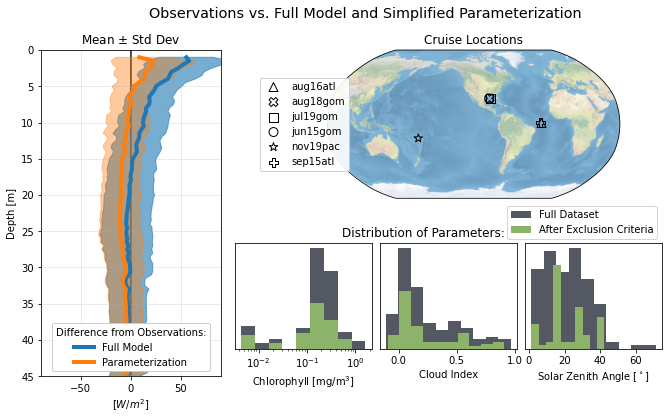

In [23]:
avgpos = all_ships.reset_coords(names=['lat','lon']).groupby('cruise').mean()

cfull = (0.32941176470588235, 0.34509803921568627, 0.38823529411764707)
csub = (0.5490196078431373, 0.7019607843137254, 0.4117647058823529)

fig = plt.figure(figsize=(12,6))
axx0 = plt.subplot2grid(shape=(1,7),loc=(0,0),rowspan=1,colspan=2)

axx0.set_title('Mean $\pm$ Std Dev')
axx0.fill_betweenx(y=final_profiles.depth,x1=final_profiles.ModDiff.mean(dim='cast')-final_profiles.ModDiff.std(dim='cast'), x2=final_profiles.ModDiff.mean(dim='cast')+final_profiles.ModDiff.std(dim='cast'), color='C0',alpha=0.6)
axx0.fill_betweenx(y=final_profiles.depth,x1=final_profiles.ParamDiff.mean(dim='cast')-final_profiles.ParamDiff.std(dim='cast'), x2=final_profiles.ParamDiff.mean(dim='cast')+final_profiles.ParamDiff.std(dim='cast'), color='C1',alpha=0.4)

axx0.plot(final_profiles.ModDiff.mean(dim='cast'), final_profiles.depth, color='C0',linewidth=4)
axx0.plot(final_profiles.ParamDiff.mean(dim='cast'), final_profiles.depth, color='C1',linewidth=4)

#axx0.errorbar(x=final_profiles.ModDiff.mean(dim='cast'),y=final_profiles.depth,xerr=final_profiles.ModDiff.std(dim='cast'),capsize=2)
#axx0.errorbar(x=final_profiles.ParamDiff.mean(dim='cast'),y=final_profiles.depth,xerr=final_profiles.ParamDiff.std(dim='cast'),capsize=2)
axx0.set_xlim(-90,90)
axx0.set_ylabel('Depth [m]')
axx0.legend(['Full Model','Parameterization'],title='Difference from Observations:',loc='lower center',framealpha=0.99)
axx0.axvline(0,color='k',zorder=0)
axx0.invert_yaxis()
axx0.grid(alpha=0.3)
axx0.set_ylim(45,0)
axx0.set_xlabel('[$W/m^2$]')

axx1 = plt.subplot2grid(shape=(2,7),loc=(0,2),rowspan=1,colspan=5, projection=ccrs.Robinson(central_longitude=250))
axx1.stock_img()
axx1.set_title('Cruise Locations')
markers = ['^','X','s','o','*','P']
for idx in np.arange(len(markers)):
    axx1.scatter(avgpos.lon[idx],avgpos.lat[idx],transform=ccrs.PlateCarree(),marker=markers[idx],edgecolor='k',facecolor='None',s=80)
axx1.legend(list(avgpos.cruise.values),loc='center left',bbox_to_anchor=(-0.25,0.5),framealpha=0.9)

axx2 = plt.subplot2grid(shape=(12,14),loc=(7,4),rowspan=4,colspan=3)
axx3 = plt.subplot2grid(shape=(12,14),loc=(7,7),rowspan=4,colspan=3)
axx4 = plt.subplot2grid(shape=(12,14),loc=(7,10),rowspan=4,colspan=3)

axx2.set_xscale('log')
logbins = np.logspace(np.log10(all_data.Chl.min().item()),np.log10(all_data.Chl.max().item()),10)
all_data.Chl.plot.hist(bins=logbins,ax=axx2, color=cfull);
data_sub.Chl.plot.hist(bins=logbins,ax=axx2, color=csub);

all_data.CI1.plot.hist(ax=axx3, color=cfull);
data_sub.CI1.plot.hist(ax=axx3, color=csub);

all_data.sza.plot.hist(ax=axx4, color=cfull);
data_sub.sza.plot.hist(ax=axx4, color=csub);

axx2.set_xlabel('Chlorophyll [mg/m$^3$]')
axx3.set_xlabel('Cloud Index')
axx4.set_xlabel('Solar Zenith Angle [$^\circ$]')
axx3.set_title('Distribution of Parameters:             ')
axx4.legend(['Full Dataset','After Exclusion Criteria'],loc='upper right',bbox_to_anchor=(1,1.4))

for axis in [axx2,axx3,axx4]:
    axis.set_yticks([])
    
plt.suptitle('Observations vs. Full Model and Simplified Parameterization',fontsize='x-large')
#plt.savefig('./Figures/Obs_v_Mod_and_Param_v4.png',dpi=300,bbox_inches='tight')

## Figure 6: Spectral Composition of Incident Irradiance as a Function of Cloud Index

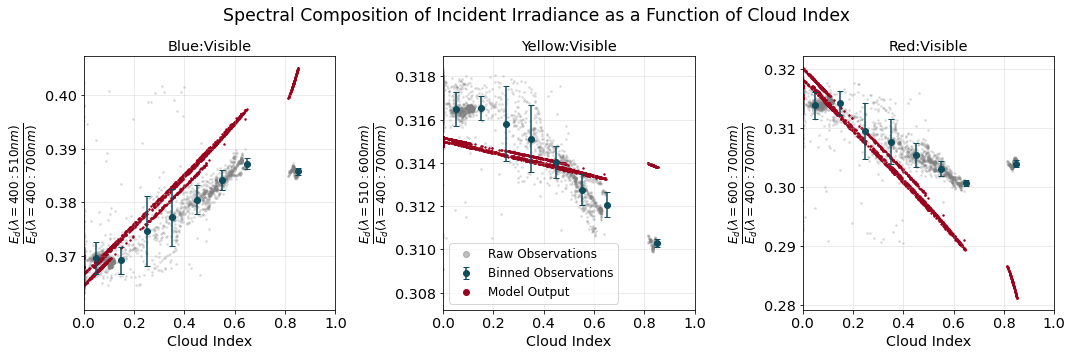

In [87]:
bb = xr.open_dataset(data_path+'hyper_surface_data.nc')

craw=(0.058823529411764705,0.2980392156862745, 0.3607843137254902)
cmod=(0.6039215686274509,0.011764705882352941,0.11764705882352941)
cOS =(0.984313725490196,0.5450980392156862,0.1411764705882353)

bb_mn = bb.groupby_bins('CI',np.linspace(0,1,11)).mean()
bb_std = bb.groupby_bins('CI',np.linspace(0,1,11)).std()
CI_bins = [b.mid for b in bb_mn.CI_bins.values]

fig,axx = plt.subplots(figsize=(15,5),ncols=3)
axx[0].scatter(bb.CI,bb.B_frac,s=3,color='gray',alpha=0.2)
h2 = axx[0].errorbar(x=CI_bins, y=bb_mn.B_frac, yerr=bb_std.B_frac,fmt='o',capsize=3,color=craw)
axx[0].scatter(bb.CI, bb.BFrac_mod,color=cmod, s=2)

h1 = mlines.Line2D(bb.CI,bb.B_frac,color='gray',alpha=0.5,marker='o',linestyle="None")
h3 = mlines.Line2D(bb.CI,bb.BFrac_mod,color=cmod,marker='o',linestyle="None")

#axx[0].set_ylim([0.4,0.6])
axx[0].set_ylabel(r'$\frac{E_d(λ=400:510nm)}{E_d(λ=400:700nm)}$',fontsize='xx-large')
axx[0].set_title('Blue:Visible',fontsize='x-large')


axx[1].scatter(bb.CI,bb.Y_frac,s=3,color='gray',alpha=0.2)
axx[1].errorbar(x=CI_bins, y=bb_mn.Y_frac, yerr=bb_std.Y_frac,fmt='o',capsize=3,color=craw)
axx[1].scatter(bb.CI, bb.YFrac_mod,color=cmod, s=2)

axx[1].legend([h1,h2,h3],['Raw Observations','Binned Observations','Model Output'],fontsize='large',loc='lower left')#,'Ohlmann & Siegel 2000'])


#axx[1].set_ylim([0.43,0.47])
axx[1].set_ylabel(r'$\frac{E_d(λ=510:600nm)}{E_d(λ=400:700nm)}$',fontsize='xx-large')
axx[1].set_title('Yellow:Visible',fontsize='x-large')

axx[2].scatter(bb.CI,bb.R_frac,s=3,color='gray',alpha=0.2)
axx[2].errorbar(x=CI_bins, y=bb_mn.R_frac, yerr=bb_std.R_frac,fmt='o',capsize=3,color=craw)
axx[2].scatter(bb.CI, bb.RFrac_mod,color=cmod, s=2)

axx[2].set_ylabel(r'$\frac{E_d(λ=600:700nm)}{E_d(λ=400:700nm)}$',fontsize='xx-large')
axx[2].set_title('Red:Visible',fontsize='x-large')


for axis in axx:
    axis.set_xlim([0,1])
    axis.grid(alpha=0.3)
    axis.set_xlabel('Cloud Index',fontsize='x-large')
    axis.tick_params(axis='both', which='major', labelsize='x-large')

plt.suptitle('Spectral Composition of Incident Irradiance as a Function of Cloud Index',fontsize='xx-large')
    
plt.tight_layout()

## Figure 7: Albedo Observations vs. Model

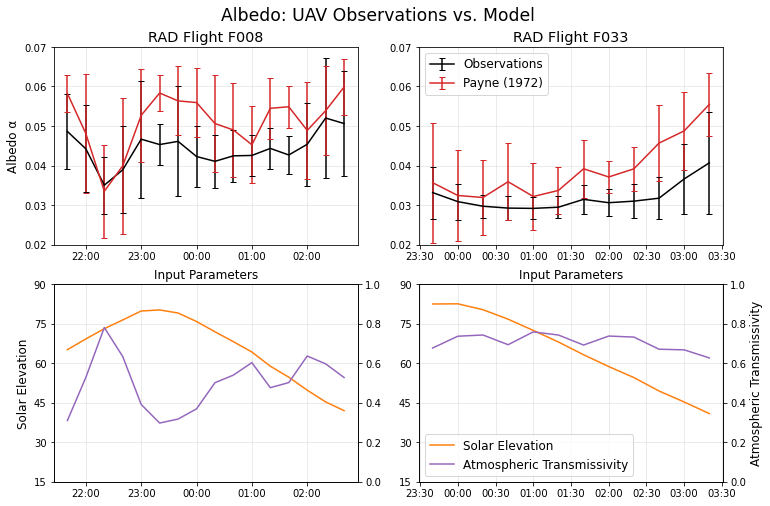

In [100]:
F008 = pd.read_csv(data_path+'F008_RAD_processed.csv', index_col=0,parse_dates=True)
F033 = pd.read_csv(data_path+'F033_RAD_processed.csv', index_col=0,parse_dates=True)

fig,axx = plt.subplots(ncols=2,nrows=2,figsize=(12,8),facecolor='w')
axidx = 0
for flight in [F008, F033]:
    axx[0,axidx].errorbar(x=flight.index,y=flight.albedo,yerr=flight.albedo_std+0.05*flight.albedo,color='k',capsize=3)
    axx[0,axidx].errorbar(x=flight.index,y=flight.albedo_model,yerr=flight.albedo_model_std+0.05*flight.albedo_model, color='C3',capsize=3)
    
    #axx[1,axidx].plot(flight.index,flight.elev,'C0')
    axx[1,axidx].plot(flight.index,flight.Sun_Altitude,'C1')
    par1 = axx[1,axidx].twinx()
    par1.plot(flight.index,flight['T'],'C4')
    par1.set_ylim(0,1)
    
    axidx = axidx+1
    
for axis in axx[0,:]:
    axis.grid(alpha=0.3)
    axis.set_ylim([0.02,0.07])
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
    
for axis in axx[1,:]:
    axis.set_ylim(15,90)
    axis.set_yticks([15,30,45,60,75,90])
    axis.grid(alpha=0.3)
    axis.set_title('Input Parameters')
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
    
axx[0,0].set_ylabel('Albedo α',fontsize='large')
axx[1,0].set_ylabel('Solar Elevation',fontsize='large')
par1.set_ylabel('Atmospheric Transmissivity',fontsize='large')
axx[0,0].set_title('RAD Flight F008',fontsize='x-large')
axx[0,1].set_title('RAD Flight F033',fontsize='x-large')
plt.suptitle('Albedo: UAV Observations vs. Model',y=0.95,fontsize='xx-large')

axx[0,1].legend(['Observations','Payne (1972)'],loc='upper left',fontsize='large')
axx[1,1].legend([mlines.Line2D(flight.index,flight.Sun_Altitude,color='C1'), mlines.Line2D(flight.index,flight['T'],color='C4')],['Solar Elevation','Atmospheric Transmissivity'],loc='lower left',fontsize='large')


## Figure 8: Sensitivity of DWL to Chlorophyll Concentration

In [33]:
eng = matlab.engine.start_matlab()
data = fk

#Warm Skin COARE
zi_default = 600.0
height = 9.5 #height of foremast metpak above waterline (m) - must be a float
bulkdepth = 2.6 #location of intake valve below waterline (m) from John's memory (he's following up)

time = pd.to_datetime(data.time.values)
yday = matlab.double((time.dayofyear + ((time.hour)/(24.0)) + (time.minute/(24.0*60)) + (time.second/(24.0*60*60))).to_list())
Ur = matlab.double(list(data['RelWindSpd-FM'].values)) #wind speed (m/s) relative to water at height zu
zu = matlab.double((np.zeros(len(time))+height).tolist()) #height (m) of wind measurement
Tair = matlab.double(list(data['AirTemp-FM'].values)) # air temp (degC)at height zt
zt = zu #height (m) of air temperature measurement
RH = matlab.double(list(data['RelHum-FM'].values)) #relative humidity (%) at height zq
zq = zu #height (m) of air humidity measurement
Pair = matlab.double(list(data['AirPres-FM'].values)) #air pressure (mb)
Tsea = matlab.double(list(data['TSGIntakeTemp'].values)) #bulk surface sea temp (degC) at ts_depth
ts_depth = matlab.double((np.zeros(len(time))+bulkdepth).tolist()) #depth (m) of water temperature measurement
Solar = matlab.double(list(data.SW.where(data.SW>0,other=0).values)) #downward solar flux (w/m^2) defined positive down
IR = matlab.double(list(data.LW.values)) #downward IR flux (w/m^2) defined positive down
Lat = matlab.double(list(data.Latitude.values)) #latitude (deg N=+)
Lon = matlab.double(list(data.Longitude.values)) #longitude (deg E=+)
zi = matlab.double((np.zeros(len(time))+zi_default).tolist()) #inversion height (m)
Rainrate = matlab.double((np.zeros(len(time))).tolist()) #rain rate (mm/hr)

coare_out_warmlayer = eng.coare35vnWarm(yday,Ur,height,Tair,height,RH,height,Pair,Tsea,Solar,IR,Lat,Lon,zi_default,Rainrate,bulkdepth)
coare_warmlayer = pd.DataFrame(index=data.time.values,data=np.asarray(coare_out_warmlayer),columns=['ustar', 'tau', 'sensible_flux', 'latent_flux', 'buoyancy_flux', 'hsbb', 'hlwebb', 'tsr', 'qsr', 'zot', 'zoq', 'Cd', 'Ch', 'Ce', 'L', 'zet', 'dter', 'dqer', 'tkt', 'Urf', 'Trf', 'Qrf', 'RHrf', 'UrfN', 'Rnl', 'Le', 'rhoa', 'UN', 'U10', 'U10N', 'Cdn_10', 'Chn_10', 'Cen_10', 'RF', 'Qs', 'Evap', 'T10', 'Q10', 'RH10','dt_warmlayer','warmlayerthickness','dsea'])
coare_xr_standard = coare_warmlayer.to_xarray().rename({'index':'time'})
coare_xr_standard['SST'] = data.TSGIntakeTemp - coare_xr_standard.dter + coare_xr_standard.dsea #take temperature that was input to COARE, subtract cool-skin and add warm-layer

coare_runs=[]
Cs = [0.01,0.03,0.1,0.3,1,3]
for C in tqdm(Cs):
    Chl = matlab.double((np.zeros(len(time))+C).tolist())
    coare_out_warmlayer = eng.coare35vnWarm_witteRadHeat(yday,Ur,height,Tair,height,RH,height,Pair,Tsea,Solar,IR,Lat,Lon,zi_default,Rainrate,bulkdepth,Chl)
    coare_warmlayer = pd.DataFrame(index=data.time.values,data=np.asarray(coare_out_warmlayer),columns=['ustar', 'tau', 'sensible_flux', 'latent_flux', 'buoyancy_flux', 'hsbb', 'hlwebb', 'tsr', 'qsr', 'zot', 'zoq', 'Cd', 'Ch', 'Ce', 'L', 'zet', 'dter', 'dqer', 'tkt', 'Urf', 'Trf', 'Qrf', 'RHrf', 'UrfN', 'Rnl', 'Le', 'rhoa', 'UN', 'U10', 'U10N', 'Cdn_10', 'Chn_10', 'Cen_10', 'RF', 'Qs', 'Evap', 'T10', 'Q10', 'RH10','dt_warmlayer','warmlayerthickness','dsea'])
    coare_xr = coare_warmlayer.to_xarray().rename({'index':'time'})
    coare_xr['SST'] = data.TSGIntakeTemp - coare_xr_standard.dter + coare_xr_standard.dsea #take temperature that was input to COARE, subtract cool-skin and add warm-layer
    coare_runs.append(coare_xr)
    

Text(0.5, 0.98, 'Sensitivity of DWL to Chlorophyll Concentration (Modified COARE3.5 on FK19 Ship Dataset)')

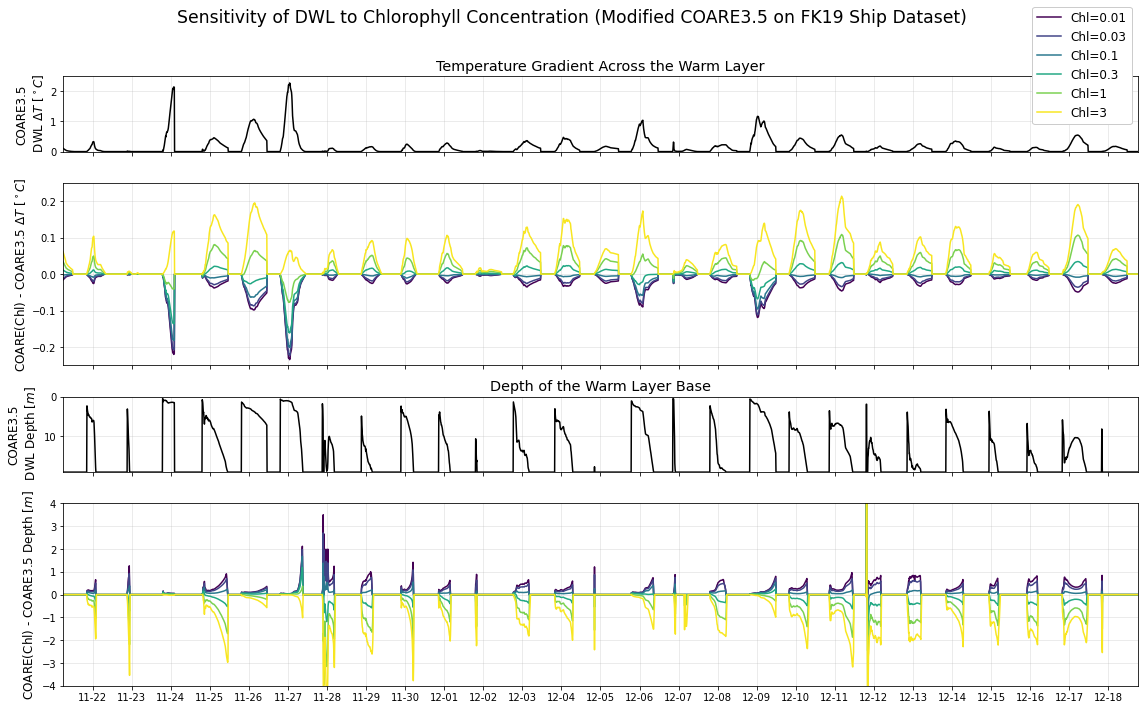

In [36]:
color_list = [0,0.2,0.4,0.6,0.8,0.99]
handles=[]

fig = plt.figure(figsize=(16,10))
axx0 = plt.subplot2grid(shape=(6,1),loc=(0,0),rowspan=1,colspan=1)
axx1 = plt.subplot2grid(shape=(6,1),loc=(1,0),rowspan=2,colspan=1)
axx2 = plt.subplot2grid(shape=(6,1),loc=(3,0),rowspan=1,colspan=1)
axx3 = plt.subplot2grid(shape=(6,1),loc=(4,0),rowspan=2,colspan=1)

h, = axx0.plot(coare_xr_standard.time,coare_xr_standard.dt_warmlayer,color='k')
axx2.plot(coare_xr_standard.time,coare_xr_standard.warmlayerthickness,color='k')
#handles.append(h)

for coare,c in zip(coare_runs,color_list):
    color = plt.cm.viridis(c)
    h1, = axx1.plot(coare.time,coare.dt_warmlayer - coare_xr_standard.dt_warmlayer,color=color)
    handles.append(h1)
    axx3.plot(coare.time,coare.warmlayerthickness - coare_xr_standard.warmlayerthickness,color=color)

for axis in [axx0,axx1,axx2,axx3]:
    axis.grid(alpha=0.3)
    axis.set_xlim(start19,end19)
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    
for axis in [axx0,axx1,axx2]:
    axis.set_xticklabels([])
axx3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
axx0.legend(handles,['Chl=0.01','Chl=0.03','Chl=0.1','Chl=0.3','Chl=1','Chl=3'], fontsize='large', loc='upper right',framealpha=1,bbox_to_anchor=(1,2))#,title='Chlorophyll')
axx0.set_ylabel('COARE3.5\n DWL $\Delta T$ [$^\circ C$]', fontsize='large')
axx1.set_ylabel('COARE(Chl) - COARE3.5 $\Delta T$ [$^\circ C$]', fontsize='large')
axx2.set_ylabel('COARE3.5\n DWL Depth [$m$]', fontsize='large')
axx3.set_ylabel('COARE(Chl) - COARE3.5 Depth [$m$]', fontsize='large')

axx0.set_ylim([0,2.5])
axx1.set_ylim([-0.25,0.25])
axx2.set_ylim([0,19])
axx3.set_ylim([-4,4])

axx2.invert_yaxis()

axx0.set_title('Temperature Gradient Across the Warm Layer',fontsize='x-large')
axx2.set_title('Depth of the Warm Layer Base',fontsize='x-large')

plt.tight_layout()
plt.suptitle('Sensitivity of DWL to Chlorophyll Concentration (Modified COARE3.5 on FK19 Ship Dataset)', fontsize='xx-large')


_______________________________________________________________
# Appendix 1: Data Import for Figure 5


#### Alignment of Datasets

#### Solar Zenith Angle & Cloud Index Calculations

# Appendix 2: Data Import for Figure 6

Aligning SW and BB measurements as much as possible - their physical separation introduces spatial variability

NOW calculate cloud index

# Appendix 3: Data Import & Processing for Figure 7

# Figure 2 but for poster

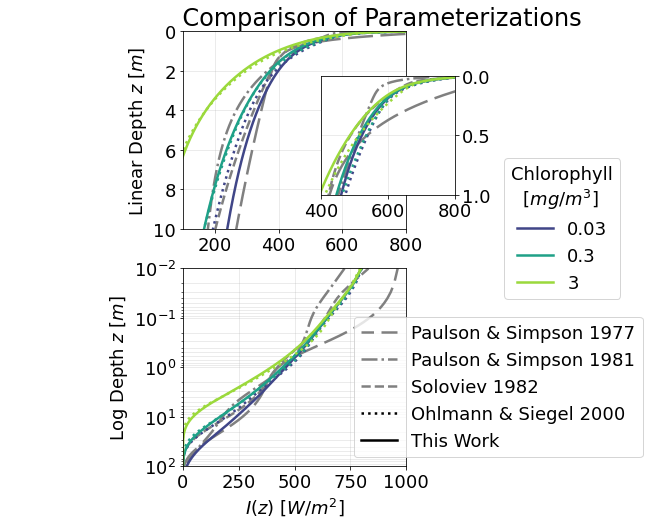

In [45]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lw = 2.5


#plot - 4 x 4: Linear axes on top, Logarithmic axes on bottom, Ed on Left, Heating on Middle, Integrated Heating to that depth on right
fig,axx = plt.subplots(nrows=2,figsize=(4,8))

#define linestyles for consistency
ls_o00 = ':' #dot
ls_s82 = '--' #small dash
ls_ps81 = '-.' #dashdot
ls_ps77 = (5, (10, 3)) #big dash
colors = [0.21,0.57,0.85]


axx[0].set_ylim([0, 10])
axx[0].invert_yaxis()
axx[0].grid(which='both',alpha=0.3)

axx[1].set_yscale('log')
axx[1].set_ylim([1e-2,1e2])
axx[1].invert_yaxis()
axx[1].grid(which='both',alpha=0.3)

#-----------IRRADIANCE COLUMN------------
#initialize inset axes
axins00 = inset_axes(axx[0], width="50%", height="50%", bbox_transform=axx[0].transAxes, bbox_to_anchor=(0.13,-0.3,1.2,1.2), borderpad=2.5)

for axis in np.append(axx,axins00):
    axis.plot(Ed_profiles.ps77, Ed_profiles.depth, color='gray',linestyle=ls_ps77,linewidth=lw)
    axis.plot(Ed_profiles.ps81, Ed_profiles.depth, color='gray',linestyle=ls_ps81,linewidth=lw)
    axis.plot(Ed_profiles.s82, Ed_profiles.depth, color='gray',linestyle=ls_s82,linewidth=lw)
    
    handles_chl = []
    for Chl,c in zip(Ed_profiles.Chl.values,colors):
        color = plt.cm.viridis(c) 
        Ed = Ed_profiles.sel(Chl=Chl)
        hchl, = axis.plot(Ed.Ed,Ed.depth, color=color,linewidth=lw)
        axis.plot(Ed.os00,Ed.depth, color=color, linestyle=ls_o00,linewidth=lw)
        handles_chl.append(hchl)
        
    axis.tick_params(which='both',labelsize=18)
    
axx[1].set_xlabel('$I(z)$ [$W/m^2$]',fontsize=18)
axx[0].set_ylabel('Linear Depth $z$ [$m$]',fontsize=18)
axx[1].set_ylabel('Log Depth $z$ [$m$]',fontsize=18)

#-----------AXIS LIMITS------------
axins00.set_ylim(0,1)
axins00.invert_yaxis()
axins00.set_xlim([400,800])
axins00.grid(alpha=0.3)
axins00.yaxis.tick_right()
        
axx[0].set_xlim(100,800)
axx[1].set_xlim(0,1000)

#--------------LEGENDS-----------------
l1 = axx[1].legend(handles_chl,[0.03,0.3,3],loc='lower right',bbox_to_anchor=(2,0.8),title='Chlorophyll\n  [$mg/m^3$]',fontsize=18,title_fontsize=18)

ls_o00 = ':' #dot
ls_s82 = '--' #small dash
ls_ps81 = '-.' #dashdot
ls_ps77 = (5, (10, 3)) #big dash

artist_77 = mlines.Line2D([], [], color='gray', linestyle=ls_ps77,linewidth=lw)
artist_81 = mlines.Line2D([], [], color='gray', linestyle=ls_ps81,linewidth=lw)
artist_82 = mlines.Line2D([], [], color='gray', linestyle=ls_s82,linewidth=lw)
artist_00 = mlines.Line2D([], [], color='k', linestyle=ls_o00,linewidth=lw)
artist_23 = mlines.Line2D([], [], color='k',linewidth=lw)

axx[1].legend([artist_77,artist_81,artist_82,artist_00,artist_23],['Paulson & Simpson 1977','Paulson & Simpson 1981','Soloviev 1982','Ohlmann & Siegel 2000','This Work'],loc='lower right',bbox_to_anchor=(2.1,0.0001),fontsize=18)
axx[1].add_artist(l1)

#for axis in axx:
    

#----------FINAL FORMATTING------------
axx[0].set_title('                       Comparison of Parameterizations', fontsize=24)

#plt.suptitle(f'',fontsize='xx-large',y=0.95)       
plt.savefig('../2. DWL models vs SPIP/Figures/For Poster/Heating_param_compare_v1.png', dpi=300, bbox_inches='tight')